In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib

from omegaconf import OmegaConf
from hydra.utils import instantiate
from experiments.utils import initialize_evaluation
from dpconvcnp.data.gp import RandomScaleGPGenerator
from dpconvcnp.data.waveform import WaveformGenerator
import tensorflow as tf
import json

OmegaConf.register_new_resolver("eval", eval)

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

2024-05-21 10:56:14.704680: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 10:56:15.246345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 10:56:16.396093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
eq_experiment_path = os.path.join(
    "/scratches",
    "cblgpu07",
    "em626",
    "dpconvcnp",
    "_experiments",
    "__cblgpu09",
    "_24_01_23",
    "full_model",
    "eq-0.20-2.50_e-0.90-4.00_lt-1_dpt-1_dpa-1",
)

eq_evaluation_config = os.path.join(
    "/scratches",
    "cblgpu07",
    "em626",
    "dpconvcnp",
    "experiments",
    "config",
    "dpconvcnp-synthetic-eval.yml",
)

sawtooth_experiment_path = os.path.join(
    "/scratches",
    "cblgpu07",
    "em626",
    "dpconvcnp",
    "_experiments",
    "__cblgpu09",
    "_24_01_23",
    "full_model",
    "sawtooth-0.20-1.25_e-0.90-4.00_lt-1_dpt-1_dpa-1",
)

sawtooth_evaluation_config = os.path.join(
    "/scratches",
    "cblgpu07",
    "em626",
    "dpconvcnp",
    "experiments",
    "config",
    "dpconvcnp-waveform-eval.yml",
)


def make_model_and_generator(data, epsilon, param, master_seed):

    if data == "eq":
        model, seed, _, _, _, _, _ = initialize_evaluation(
            experiment_path=eq_experiment_path,
            evaluation_config=eq_evaluation_config,
        )

        generator = RandomScaleGPGenerator(
            seed=[master_seed, 0],
            dim=1,
            kernel_type="eq",
            min_log10_lengthscale=np.log10(param),
            max_log10_lengthscale=np.log10(param),
            noise_std=0.2,
            min_num_ctx=512,
            max_num_ctx=512,
            min_num_trg=128,
            max_num_trg=128,
            context_range=[[-2.0, 2.0]],
            target_range=[[-2.0, 2.0]],
            samples_per_epoch=2,
            batch_size=1,
            min_epsilon=epsilon,
            max_epsilon=epsilon,
            min_log10_delta=-3,
            max_log10_delta=-3,
        )
    
    elif data == "sawtooth":
        model, seed, _, _, _, _, _ = initialize_evaluation(
            experiment_path=sawtooth_experiment_path,
            evaluation_config=sawtooth_evaluation_config,
        )

        generator = WaveformGenerator(
            seed=[master_seed, 0],
            dim=1,
            waveform_func="sawtooth",
            min_num_ctx=512,
            max_num_ctx=512,
            min_num_trg=128,
            max_num_trg=128,
            context_range=[[-2.0, 2.0]],
            target_range=[[-2.0, 2.0]],
            noise_std=0.2,
            samples_per_epoch=2,
            min_frequency=param,
            max_frequency=param,
            batch_size=1,
            min_epsilon=epsilon,
            max_epsilon=epsilon,
            min_log10_delta=-3,
            max_log10_delta=-3,
        )

    return seed, model, generator

2024-05-21 10:56:26.921211: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-21 10:56:26.921307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: cblgpu07
2024-05-21 10:56:26.921327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: cblgpu07
2024-05-21 10:56:26.921520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2024-05-21 10:56:26.921564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2024-05-21 10:56:26.921574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


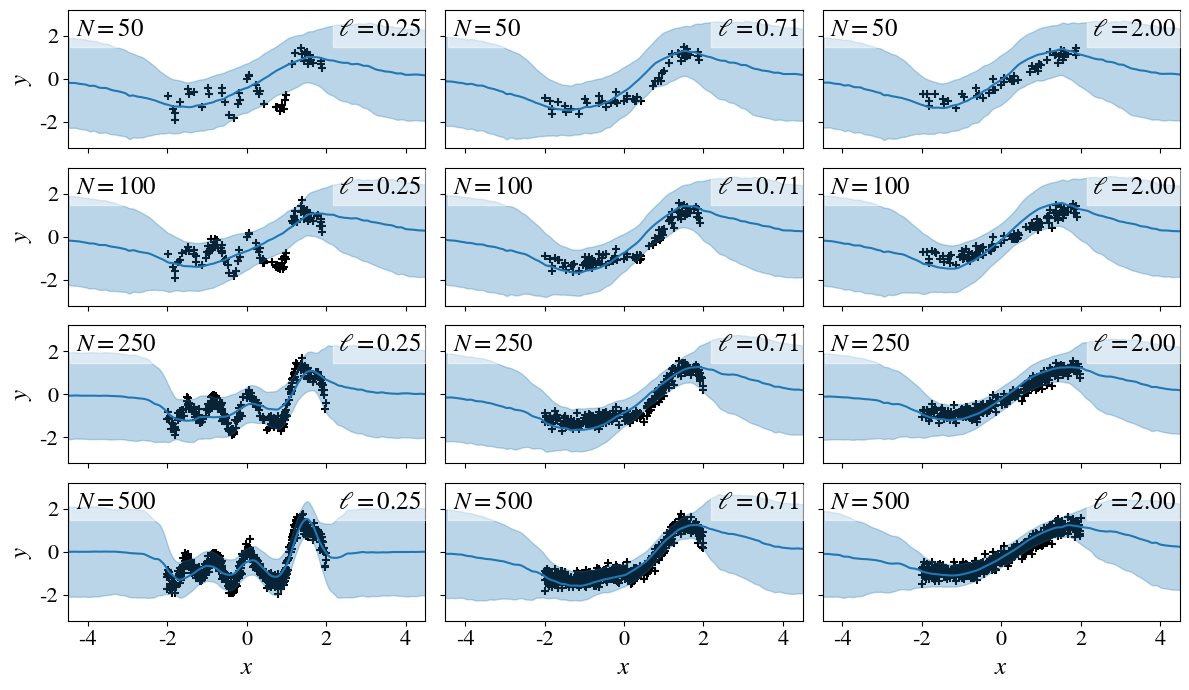

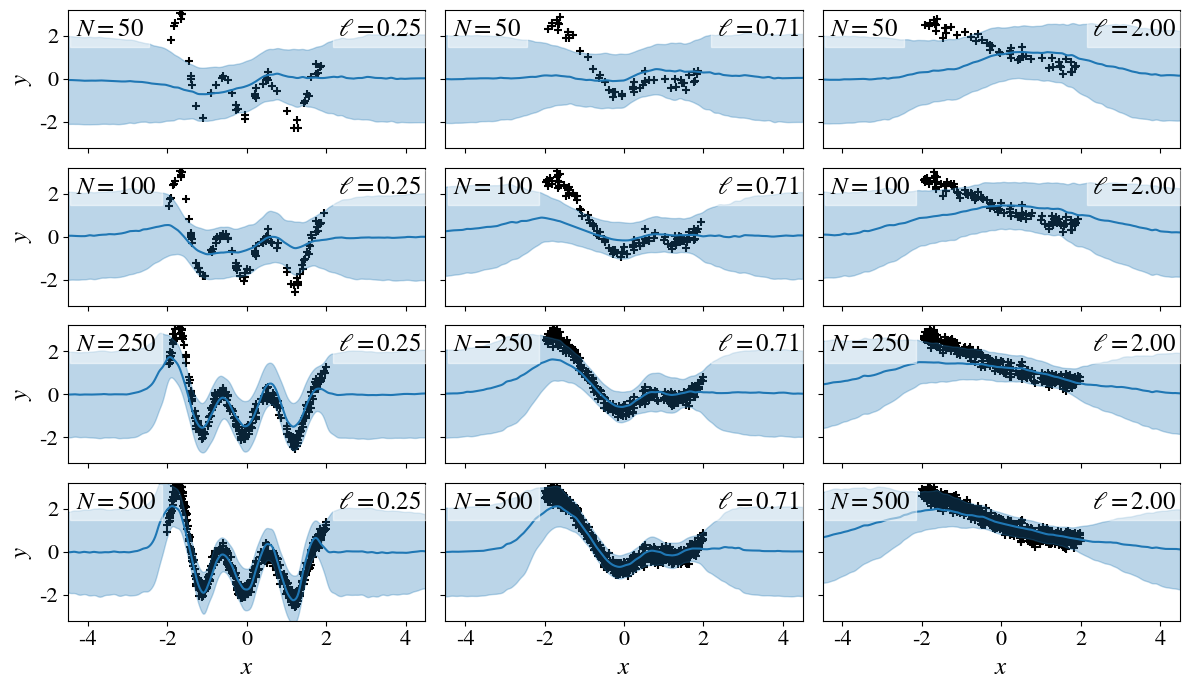

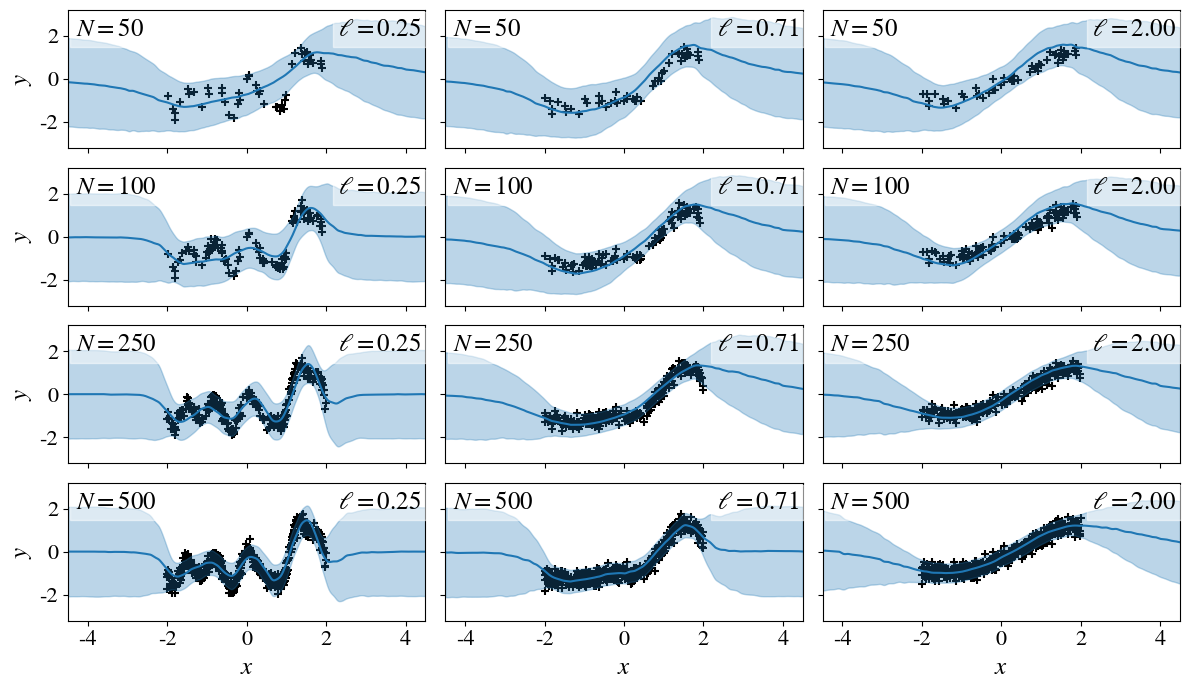

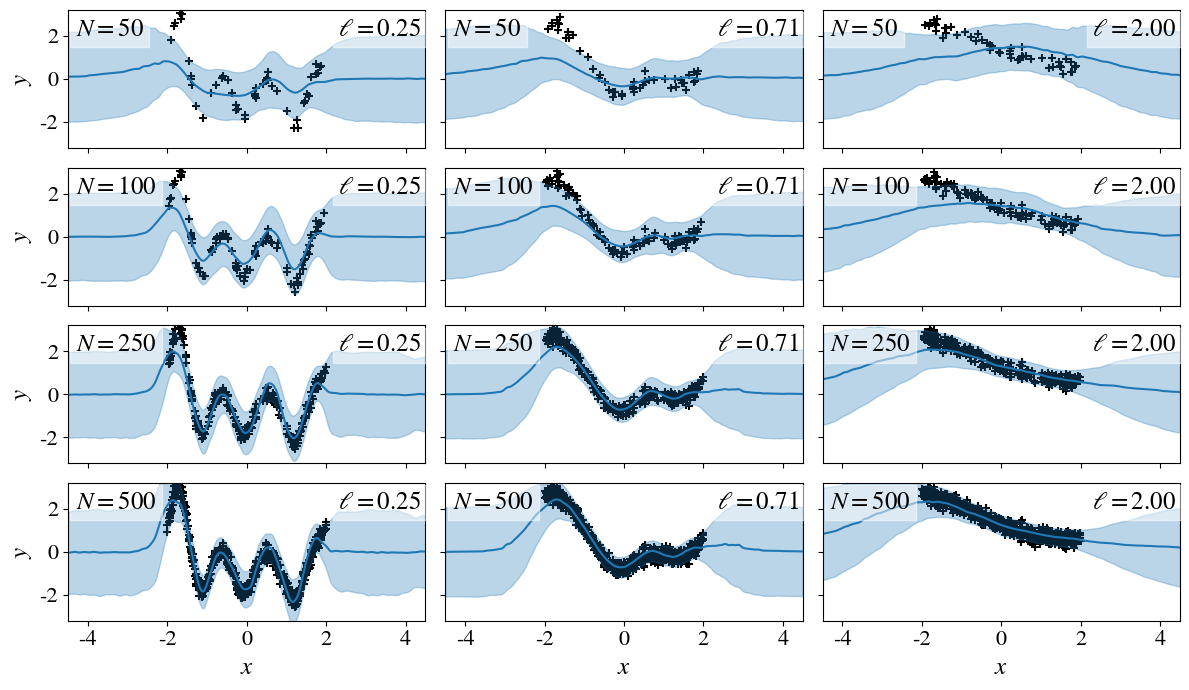

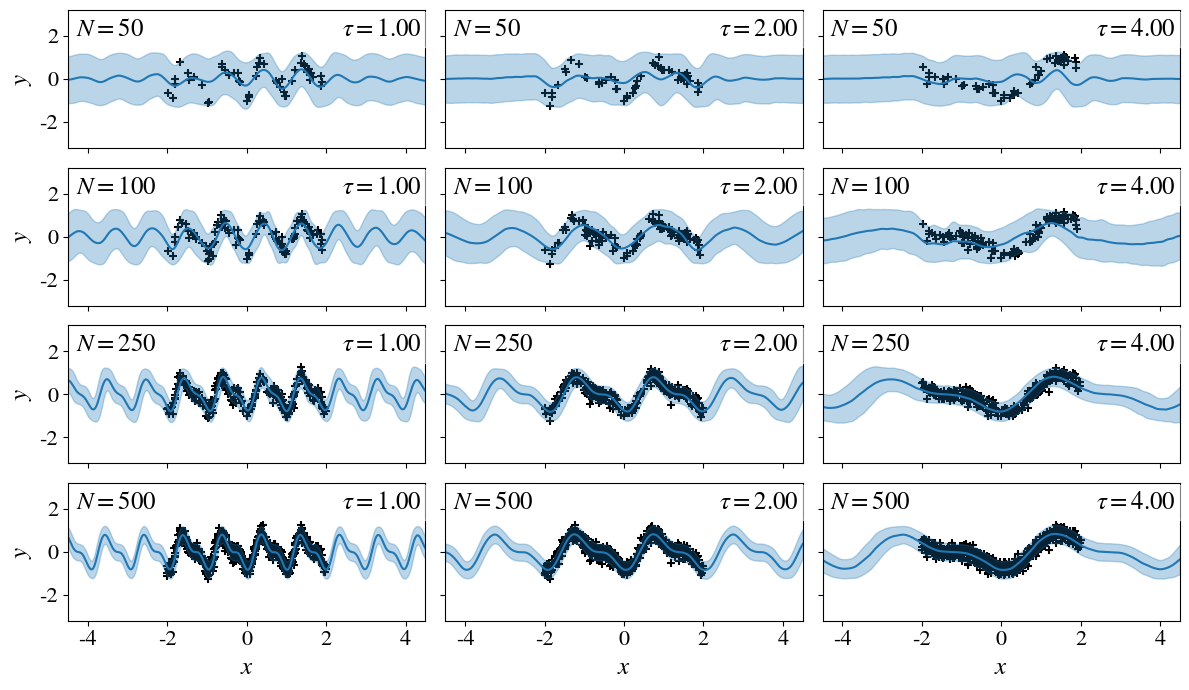

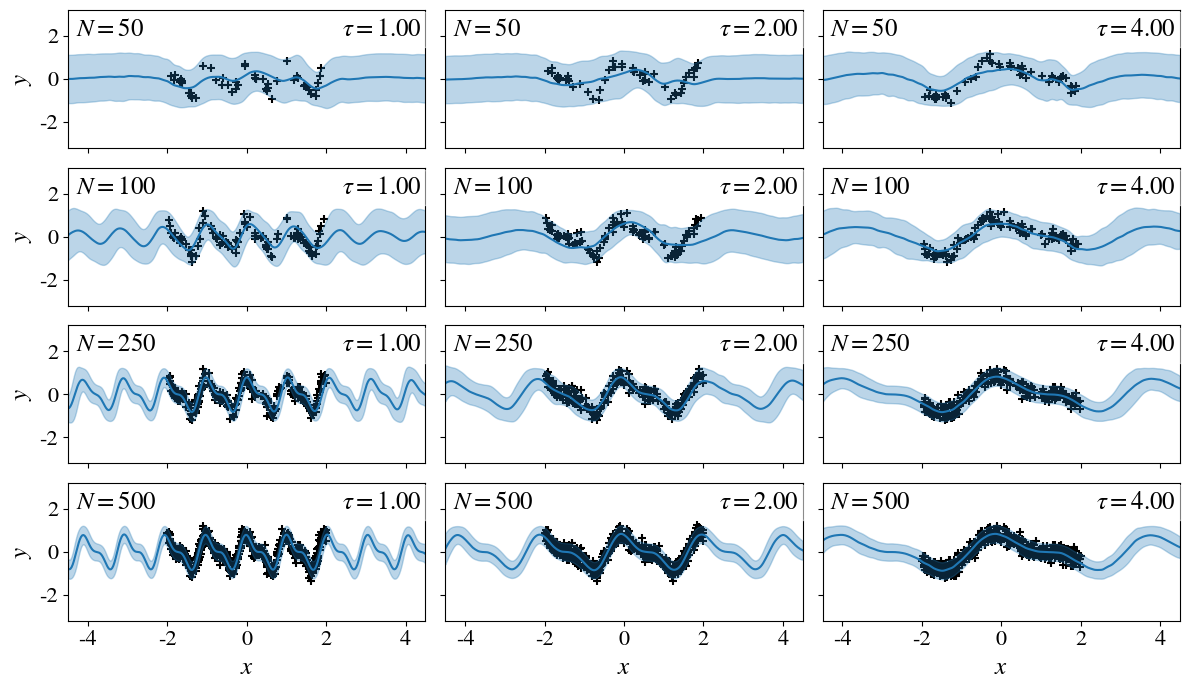

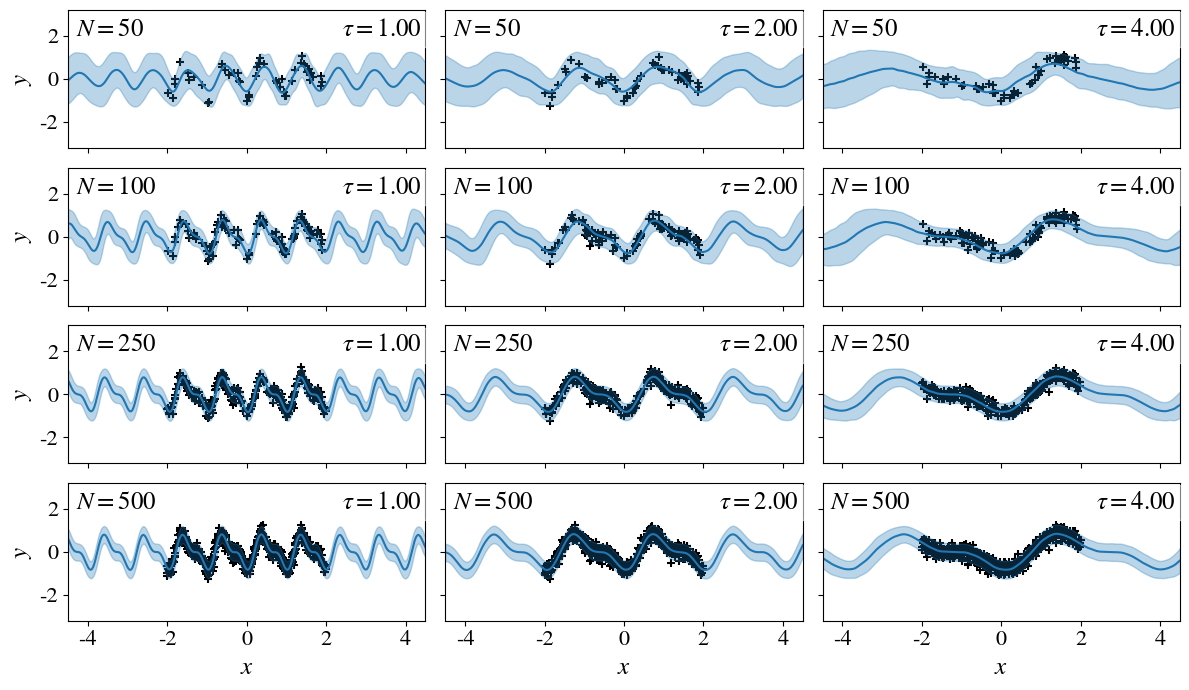

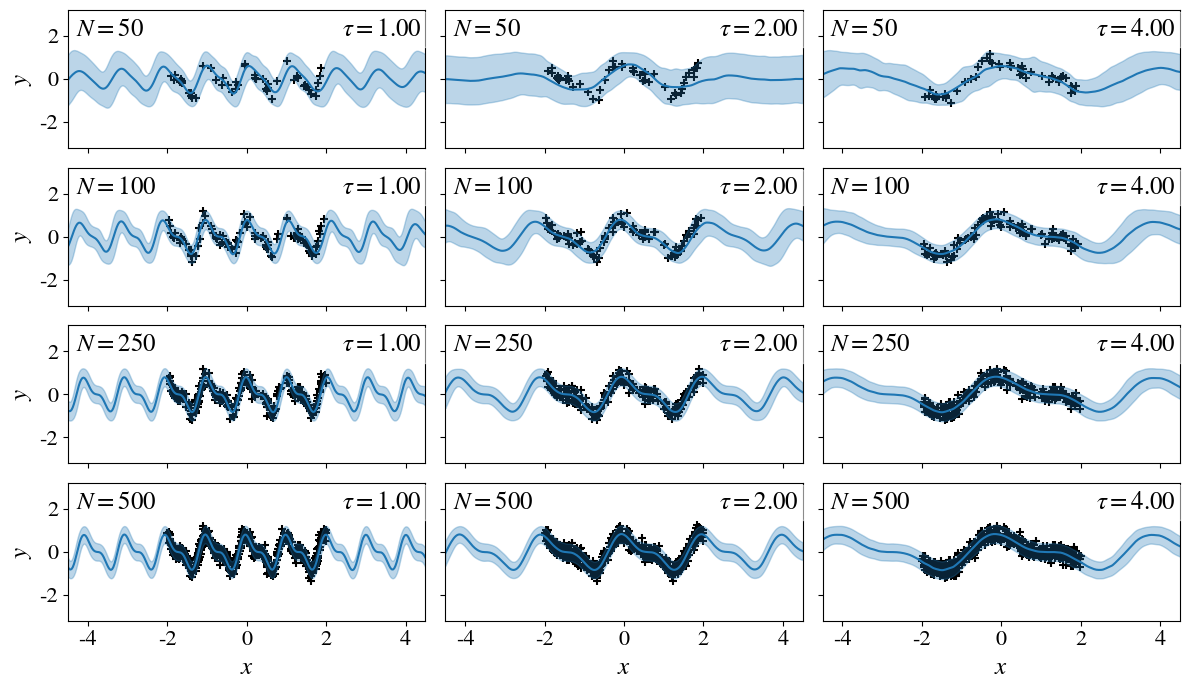

In [3]:
data = {
    "eq": ([0.25, 0.71, 2.00], "\\ell"),
    "sawtooth": ([1.00, 0.50, 0.25], "\\tau"),
}

N = [50, 100, 250, 500]

x_plot = tf.linspace(-4.5, 4.5, 300)[None, :, None]
x_plot = tf.repeat(x_plot, 2, axis=0)

for k, (params, p_name) in data.items():
    for epsilon in [1.0, 3.0]:
        for master_seed in [100, 200]:

            fig, ax = plt.subplots(len(N), len(params), figsize=(12, 7), sharex=True, sharey=True)
            for j, p in enumerate(params):
                for i, n in enumerate(N):

                    seed, model, generator = make_model_and_generator(k, epsilon, p, master_seed)

                    for batch in generator:
                        seed, mean, std = model(
                            seed=seed,
                            x_ctx=batch.x_ctx[:, :n, :],
                            y_ctx=batch.y_ctx[:, :n, :],
                            x_trg=x_plot,
                            epsilon=batch.epsilon,
                            delta=batch.delta,
                        )
                        break
                    
                    ax[i, j].scatter(
                        batch.x_ctx[0, :n, 0],
                        batch.y_ctx[0, :n, 0],
                        label="Context",
                        color="black",
                        marker="+",
                    )

                    ax[i, j].plot(
                        x_plot[0, :, 0],
                        mean[0, :, 0],
                        color="tab:blue",
                    )

                    ax[i, j].fill_between(
                        x_plot[0, :, 0],
                        mean[0, :, 0] - 2 * std[0, :, 0],
                        mean[0, :, 0] + 2 * std[0, :, 0],
                        color="tab:blue",
                        alpha=0.3,
                    )
                    ax[i, j].set_xlim([-4.5, 4.5])
                    ax[i, j].set_ylim([-3.2, 3.2])

                    if i == len(N) - 1:
                        ax[i, j].set_xlabel(f"$x$", fontsize=18)
                        ax[i, j].set_xticks([-4, -2, 0, 2, 4], [-4, -2, 0, 2, 4], fontsize=16)

                    if j == 0:
                        ax[i, j].set_ylabel(f"$y$", fontsize=18)
                        ax[i, j].set_yticks([-2, 0, 2], [-2, 0, 2], fontsize=16)
                
                    pplot = p if k == "eq" else 1 / p
                    t = ax[i, j].text(
                        -4.30,
                        2.00,
                        f"$N={n}$",
                        horizontalalignment="left",
                        fontsize=18,
                    )
                    t.set_bbox(dict(facecolor="white", alpha=0.5, edgecolor="white"))
                    t = ax[i, j].text(
                        4.40,
                        2.00,
                        f"${p_name}={pplot:.2f}$",
                        horizontalalignment="right",
                        fontsize=18,
                    )
                    t.set_bbox(dict(facecolor="white", alpha=0.5, edgecolor="white"))

            plt.tight_layout()
            plt.savefig(f"fig-tmp/{k}_e-{epsilon}_seed-{master_seed}.pdf")
            plt.show()

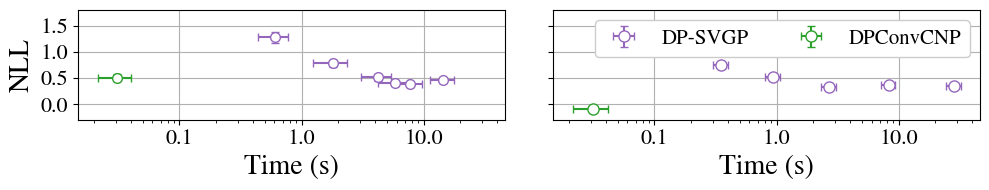

In [ ]:
def load_time(variable, epochs, num_points):
    results = json.load(open(f"{variable}-time/{variable}-time-epochs-{epochs}-time-results.json", "r"))
    performance = json.load(open(f"{variable}-time/{variable}-time-epochs-{epochs}-results.json", "r"))

    return (
        results["mean_train_and_inference_time"],
        results["ste_train_and_inference_time"],
        performance["interpolation/lengthscale-0.71"]["1.0"][f"{num_points}"]["mean_nll"],
        performance["interpolation/lengthscale-0.71"]["1.0"][f"{num_points}"]["ste_nll"],
    )


variable = "eq"
num_points = 200

epochs = [1, 3, 10, 30, 100, 300]

dpgp_mean_time, dpgp_ste_time, dpgp_mean_nll, dpgp_ste_nll = zip(*[load_time(variable, epoch, num_points) for epoch in epochs])

fig, ax = plt.subplots(1, 2, figsize=(10, 2), sharex=True, sharey=True)
ax[0].errorbar(
    dpgp_mean_time,
    dpgp_mean_nll,
    xerr=2*np.array(dpgp_ste_time),
    yerr=2*np.array(dpgp_ste_nll),
    linestyle="",
    marker="o",
    color="tab:purple",
    linewidth=1.5,
    markersize=7,
    markerfacecolor="white",
    label="DP-SVGP",
    capsize=3,
)

ax[0].errorbar(
    np.mean(eq_times),
    np.mean(eq_losses),
    xerr=2*np.std(eq_times)/np.sqrt(len(eq_times)),
    yerr=2*np.std(eq_losses)/np.sqrt(len(eq_losses)),
    marker="o",
    linestyle="",
    color="tab:green",
    linewidth=1.5,
    markersize=7,
    markerfacecolor="white",
    capsize=3,
    label="DPConvCNP",
)



def load_time(variable, epochs, num_points):
    results = json.load(open(f"{variable}-time/{variable}-time-epochs-{epochs}-time-results.json", "r"))
    performance = json.load(open(f"{variable}-time/{variable}-time-epochs-{epochs}-results.json", "r"))

    return (
        results["train_and_inference_times_mean"],
        results["train_and_inference_times_ste"],
        performance["interpolation/frequency-0.5"]["1.0"][f"{num_points}"]["mean_nll"],
        performance["interpolation/frequency-0.5"]["1.0"][f"{num_points}"]["ste_nll"],
    )


variable = "sawtooth"
num_points = 200

epochs = [1, 3, 10, 30, 100]

dpgp_mean_time, dpgp_ste_time, dpgp_mean_nll, dpgp_ste_nll = zip(*[load_time(variable, epoch, num_points) for epoch in epochs])

ax[1].errorbar(
    dpgp_mean_time,
    dpgp_mean_nll,
    xerr=2*np.array(dpgp_ste_time),
    yerr=2*np.array(dpgp_ste_nll),
    marker="o",
    linestyle="",
    color="tab:purple",
    linewidth=1.5,
    markersize=8,
    markerfacecolor="white",
    capsize=3,
    label="DP-SVGP",
)
ax[1].errorbar(
    np.mean(sawtooth_times),
    np.mean(sawtooth_losses),
    xerr=2*np.std(sawtooth_times)/np.sqrt(len(sawtooth_times)),
    yerr=2*np.std(sawtooth_losses)/np.sqrt(len(sawtooth_losses)),
    marker="o",
    linestyle="",
    color="tab:green",
    linewidth=1.5,
    markersize=8,
    markerfacecolor="white",
    capsize=3,
    label="DPConvCNP",
)
ax[0].set_ylabel("NLL", fontsize=20)
ax[1].set_xscale("log")
ax[0].set_xticks([0.1, 1.0, 10.0], [0.1, 1.0, 10.0], fontsize=16)
ax[1].set_xticks([0.1, 1.0, 10.0], [0.1, 1.0, 10.0], fontsize=16)
ax[0].set_yticks([0.0, 0.5, 1.0, 1.5], [0.0, 0.5, 1.0, 1.5], fontsize=16)
ax[0].set_ylim([-0.3, 1.8])
ax[0].set_xlabel("Time (s)", fontsize=20)
ax[1].set_xlabel("Time (s)", fontsize=20)
ax[1].legend(ncol=2, fontsize=15, framealpha=1.0)
ax[0].grid("on")
ax[1].grid("on")
plt.tight_layout()
plt.savefig("timing.pdf")
plt.show()